In [1]:
# Installing necessary dependencies
try:
    import pyspark
except ModuleNotFoundError:
    !pip install pyspark

try:
    import tensorflow as tf
except ModuleNotFoundError:
    !pip install tensorflow

try:
    from imblearn.over_sampling import SMOTE
except ModuleNotFoundError:
    !pip install imbalanced-learn

try:
    from flask import Flask, request, jsonify
except ModuleNotFoundError:
    !pip install flask

!pip install keras
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7f50da830e40a1a0c78c666057a63d2780f32b2da10534c36ce3927121e6e4d8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Capstone Project") \
    .getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [3]:
# Task 1: Initial Data Exploration
def initial_data_exploration(data_path):
    df = spark.read.csv(data_path, header=True, inferSchema=True, sep=",", multiLine=True)
    df = df.filter(df['Fecha'].isNotNull())
    df = df.select('Fecha', 'TCR 1/').withColumnRenamed('TCR 1/', 'TCR_1')
    return df

In [4]:
# Task 2: Extract, Transform, Load (ETL)
def etl_process(df):
    df_clean = df.dropna()
    return df_clean

In [5]:
# Task 3: Feature Creation
def feature_creation(df):
    pd_df = df.toPandas()
    pd_df['Fecha'] = pd.to_datetime(pd_df['Fecha'], format='%d/%m/%Y')

    # Scale TCR_1
    tcr_scaler = StandardScaler()
    pd_df['TCR_1_scaled'] = tcr_scaler.fit_transform(pd_df[['TCR_1']])

    # Create lag features
    for lag in range(1, 8):
        pd_df[f'TCR_1_lag_{lag}'] = pd_df['TCR_1_scaled'].shift(lag)

    pd_df.dropna(inplace=True)

    # Scale lag features
    numerical_cols = [f'TCR_1_lag_{lag}' for lag in range(1, 8)]
    scaler = StandardScaler()
    pd_df[numerical_cols] = scaler.fit_transform(pd_df[numerical_cols])

    return pd_df, scaler, tcr_scaler

In [6]:
# Task 4: Model Definition
def define_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [7]:
# Task 5: Model Training
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return history

In [8]:
# Task 6: Model Evaluation
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

In [9]:
# Task 7: Predicting Next Week's TCR_1
def predict_next_week(model, last_week_data, scaler, feature_columns, tcr_scaler):
    predictions = []
    for _ in range(7):
        # Ensure last_week_data has the correct shape (2D array)
        last_week_df = pd.DataFrame(last_week_data, columns=feature_columns)
        scaled_data = scaler.transform(last_week_df)
        next_prediction = model.predict(scaled_data)

        # Descale the prediction
        next_prediction_descaled = tcr_scaler.inverse_transform(next_prediction)
        predictions.append(next_prediction_descaled[0, 0])

        # Create new input by shifting last week data and adding the new prediction
        last_week_data = np.roll(last_week_data, -1)
        last_week_data[-1] = next_prediction[0, 0]

    return predictions

In [11]:
# Function to plot the data
def plot_data(processed_data, next_week_predictions, next_week_dates):
    plt.figure(figsize=(15, 10))

    # Plot all original data
    plt.subplot(2, 2, 1)
    plt.plot(processed_data['Fecha'], processed_data['TCR_1'], label='Original Data')
    plt.title('All Original Data')
    plt.xlabel('Date')
    plt.ylabel('TCR_1')
    plt.legend()

    # Plot last week's data
    plt.subplot(2, 2, 2)
    plt.plot(processed_data['Fecha'].tail(7), processed_data['TCR_1'].tail(7), label='Last Week')
    plt.title('Last Week Data')
    plt.xlabel('Date')
    plt.ylabel('TCR_1')
    plt.legend()

    # Plot next week's predictions
    plt.subplot(2, 2, 3)
    plt.plot(next_week_dates, next_week_predictions, label='Predictions', color='orange')
    plt.title('Next Week Predictions')
    plt.xlabel('Date')
    plt.ylabel('TCR_1')
    plt.legend()

    # Plot all data including predictions
    plt.subplot(2, 2, 4)
    plt.plot(processed_data['Fecha'], processed_data['TCR_1'], label='Original Data')
    plt.plot(next_week_dates, next_week_predictions, label='Predictions', color='orange')
    plt.title('All Data Including Predictions')
    plt.xlabel('Date')
    plt.ylabel('TCR_1')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot scatter data
def plot_scatter_data(processed_data, next_week_predictions, next_week_dates):
    plt.figure(figsize=(10, 6))

    # Scatter plot of all data including predictions
    plt.scatter(processed_data['Fecha'], processed_data['TCR_1'], label='Original Data', alpha=0.6)
    plt.scatter(next_week_dates, next_week_predictions, label='Predictions', color='orange', alpha=0.6)
    plt.title('All Data Including Predictions (Scatter Plot)')
    plt.xlabel('Date')
    plt.ylabel('TCR_1')
    plt.legend()

    plt.show()

Processed Data:
          Fecha    TCR_1  TCR_1_scaled  TCR_1_lag_1  TCR_1_lag_2  TCR_1_lag_3  \
1615 2024-06-03  7.76374      0.004101     0.062953     0.063503     0.064045   
1616 2024-06-04  7.76850      0.081951     0.000503     0.063503     0.064045   
1617 2024-06-05  7.76761      0.067395     0.078320     0.001069     0.064045   
1618 2024-06-06  7.76844      0.080969     0.063770     0.078866     0.001627   
1619 2024-06-07  7.76638      0.047278     0.077339     0.064320     0.079404   
1620 2024-06-08  7.76638      0.047278     0.043662     0.077885     0.064862   
1621 2024-06-09  7.76638      0.047278     0.043662     0.044217     0.078423   
1622 2024-06-10  7.76241     -0.017651     0.043662     0.044217     0.044764   
1623 2024-06-11  7.76323     -0.004240    -0.021240     0.044217     0.044764   
1624 2024-06-12  7.76210     -0.022721    -0.007835    -0.020668     0.044764   

      TCR_1_lag_4  TCR_1_lag_5  TCR_1_lag_6  TCR_1_lag_7  
1615     0.089619     0.126122   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 33ms/step
Next week's predictions:
Date: 2024-06-13, Predicted TCR_1: 7.7667155265808105
Date: 2024-06-14, Predicted TCR_1: 7.766206741333008
Date: 2024-06-15, Predicted TCR_1: 7.763754844665527
Date: 2024-06-16, Predicted TCR_1: 7.767348766326904
Date: 2024-06-17, Predicted TCR_1: 7.766252517700195
Date: 2024-06-18, Predicted TCR_1: 7.767632484436035
Date: 2024-06-19, Predicted TCR_1: 7.769115447998047


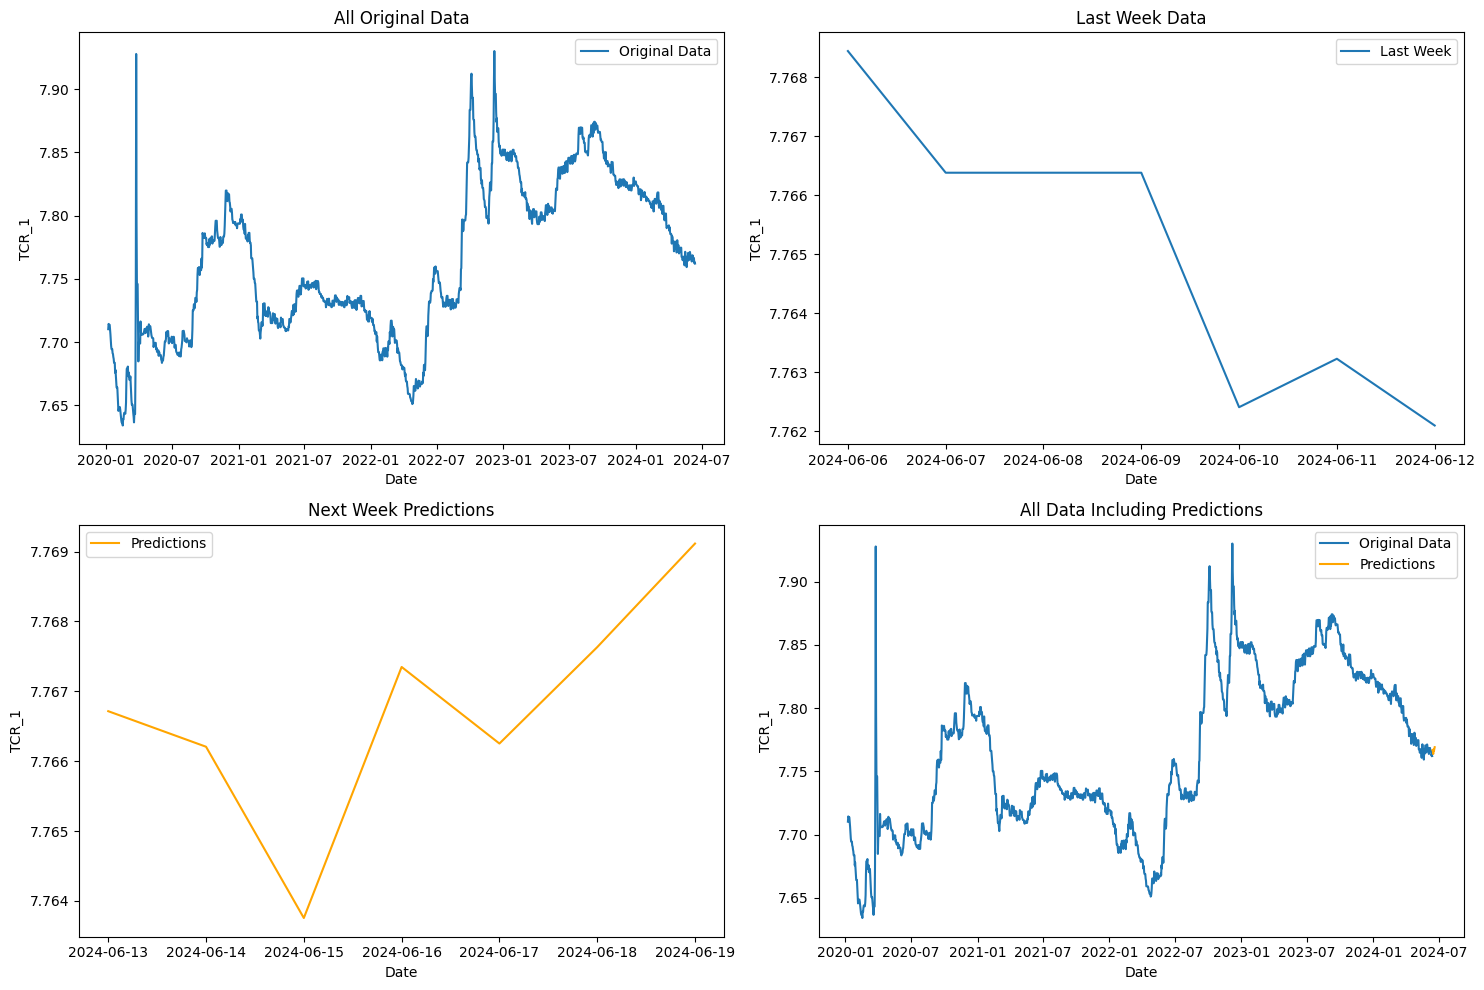

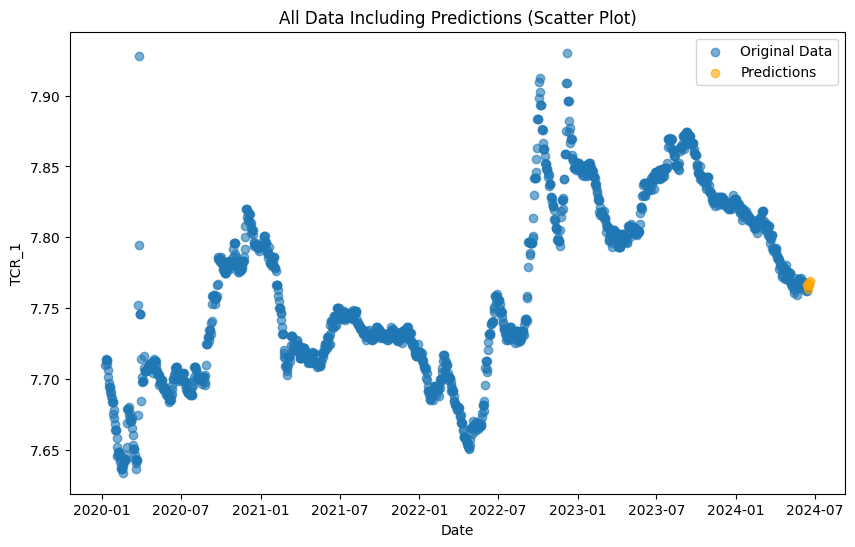

In [13]:
# Running the pipeline
if __name__ == "__main__":
    data_path = "/content/historico_rango.csv"

    df = initial_data_exploration(data_path)
    df_clean = etl_process(df)
    processed_data, scaler, tcr_scaler = feature_creation(df_clean)

    # Debugging: Print processed_data to check the columns and data
    print("Processed Data:")
    print(processed_data.tail(10))  # Print the last 10 rows for inspection

    target_column = 'TCR_1_scaled'
    feature_columns = [col for col in processed_data.columns if col.startswith('TCR_1_lag')]

    X = processed_data[feature_columns]
    y = processed_data[target_column]

    print(f"Shapes of X and y: {X.shape}, {y.shape}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Shapes of X_train, X_val, y_train, y_val: {X_train.shape}, {X_val.shape}, {y_train.shape}, {y_val.shape}")

    input_shape = X_train.shape[1]
    model = define_model(input_shape)
    train_model(model, X_train, y_train, X_val, y_val)
    evaluate_model(model, X_val, y_val)

    # Save the model
    model.save("model.h5")
    print("Model saved as model.h5")

    # Predicting the next week's TCR_1
    last_week_data = processed_data[feature_columns].tail(7).values

    # Ensure last_week_data is a 2D array
    if last_week_data.shape[0] != 7:
        last_week_data = np.tile(last_week_data, (7, 1))

    print(f"Shape of last_week_data before prediction: {last_week_data.shape}")

    next_week_predictions = predict_next_week(model, last_week_data, scaler, feature_columns, tcr_scaler)
    next_week_dates = pd.date_range(start=processed_data['Fecha'].max() + pd.Timedelta(days=1), periods=7)

    # Displaying the prediction
    print("Next week's predictions:")
    for date, pred in zip(next_week_dates, next_week_predictions):
        print(f"Date: {date.date()}, Predicted TCR_1: {pred}")

    # Plotting the data
    plot_data(processed_data, next_week_predictions, next_week_dates)

    # Plotting scatter data
    plot_scatter_data(processed_data, next_week_predictions, next_week_dates)